In [29]:
import json
import pandas as pd
import os
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd


sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CustomerChurn_EDA") \
    .master("local[*]") \
    .getOrCreate()

25/10/12 14:44:25 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
data = spark.read.parquet("../data/cleaned_churn_data.parquet")

In [10]:
data.printSchema()
data.show(5)
data.count()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- churn_flag: integer (nullable = true)

+-------+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+----------+
| userId|              arti

26259199

### I. Basic sanity checks

In [12]:
from pyspark.sql import functions as F

# Calculate the number of unique users
num_users = data.select("userId").distinct().count()
print(f"Number of unique users: {num_users}")

# Calculate the number of unique sessions
num_sessions = data.select("sessionId").distinct().count()
print(f"Number of unique sessions: {num_sessions}")

# Calculate the total number of events (rows)
num_events = data.count()
print(f"Total number of events (rows): {num_events}")

# Show all as a tuple for reference as well
counts_tuple = (num_users, num_sessions, num_events)
print(f"(num_users, num_sessions, num_events): {counts_tuple}")

Number of unique users: 22278
Number of unique sessions: 228713
Total number of events (rows): 26259199
(num_users, num_sessions, num_events): (22278, 228713, 26259199)


~26 million individual user actions recorded.

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_73969/1931752186.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=event_counts, x="count", y="page", palette="coolwarm")


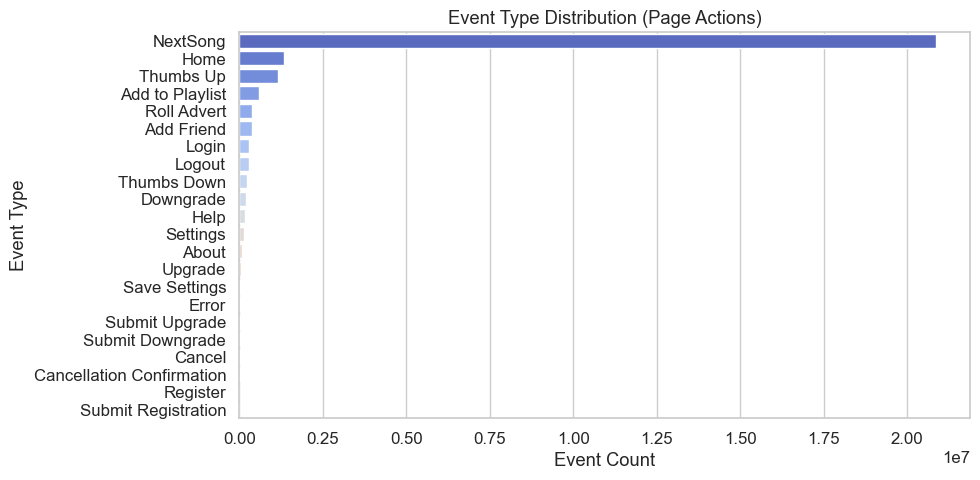

In [20]:
event_counts = (
    data.groupBy("page")
        .count()
        .orderBy(F.desc("count"))
        .toPandas()
)

plt.figure(figsize=(10,5))
sns.barplot(data=event_counts, x="count", y="page", palette="coolwarm")
plt.title("Event Type Distribution (Page Actions)")
plt.xlabel("Event Count")
plt.ylabel("Event Type")
plt.tight_layout()
plt.show()

### II. Missing values overview

In [13]:
data.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in data.columns]).show(truncate=False)

+------+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+----------+
|userId|artist |auth|firstName|gender|itemInSession|lastName|length |level|location|method|page|registration|sessionId|song   |status|ts |userAgent|churn_flag|
+------+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+----------+
|0     |5408927|0   |778479   |778479|0            |778479  |5408927|0    |778479  |0     |0   |778479      |0        |5408927|0     |0  |778479   |0         |
+------+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+----------+



### III.  Churn rate

In [14]:
data.select("userId", "churn_flag").distinct().groupBy("churn_flag").count().show()

+----------+-----+
|churn_flag|count|
+----------+-----+
|         1| 5003|
|         0|17275|
+----------+-----+



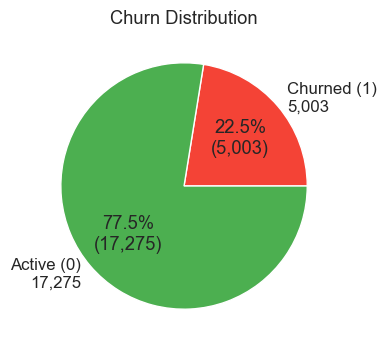

In [26]:
churn_counts = (
    data.select("userId", "churn_flag").distinct()
        .groupBy("churn_flag").count()
        .toPandas()
)

# Sort so labels and colors match: [Churned (1), Active (0)]
churn_counts_sorted = churn_counts.sort_values("churn_flag", ascending=False).reset_index(drop=True)
counts = churn_counts_sorted["count"].tolist()
labels = [f'Churned (1)\n{counts[0]:,}', f'Active (0)\n{counts[1]:,}']

plt.figure(figsize=(4,4))
plt.pie(
    churn_counts_sorted["count"], 
    labels=labels, 
    autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct/100.*sum(counts))):,})", 
    colors=["#F44336", "#4CAF50"]
)
plt.title("Churn Distribution")
plt.show()

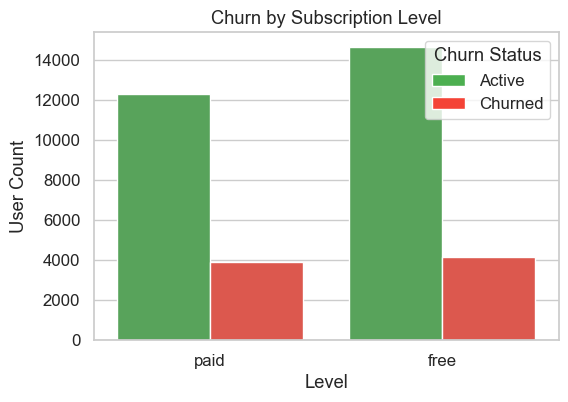

In [30]:
level_churn = (
    data.select("userId", "level", "churn_flag").distinct()
        .groupBy("level", "churn_flag").count()
        .toPandas()
)

plt.figure(figsize=(6,4))
sns.barplot(data=level_churn, x="level", y="count", hue="churn_flag", palette=["#4CAF50", "#F44336"])
plt.title("Churn by Subscription Level")
plt.xlabel("Level")
plt.ylabel("User Count")


legend_colors = ["#4CAF50", "#F44336"]
legend_labels = ["Active", "Churned"]
handles = [Patch(facecolor=c, label=l) for c, l in zip(legend_colors, legend_labels)]
plt.legend(handles=handles, title="Churn Status")
plt.show()

### IV. Gender & Level Distribution

In [15]:
data.select("userId", "gender", "level", "churn_flag").distinct().groupBy("gender", "churn_flag").count().show()
data.select("userId", "level", "churn_flag").distinct().groupBy("level", "churn_flag").count().show()

+------+----------+-----+
|gender|churn_flag|count|
+------+----------+-----+
|     M|         1| 4285|
|     F|         0|12887|
|     F|         1| 3753|
|     M|         0|14051|
|  NULL|         0|    2|
+------+----------+-----+



+-----+----------+-----+
|level|churn_flag|count|
+-----+----------+-----+
| paid|         0|12294|
| free|         0|14646|
| paid|         1| 3891|
| free|         1| 4147|
+-----+----------+-----+



/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_73969/2794262294.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


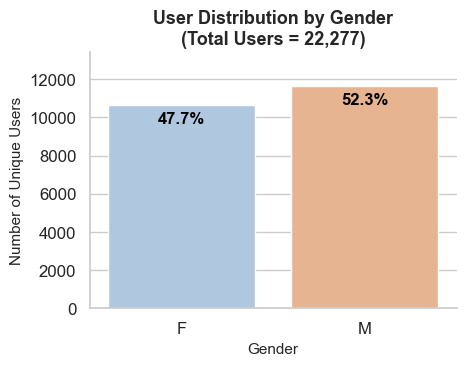

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# --- Aggregate unique users by gender, EXCLUDING NULLS ---
gender_user_counts = (
    data
    .filter(F.col("gender").isNotNull())
    .select("userId", "gender")
    .distinct()
    .groupBy("gender")
    .count()
    .withColumnRenamed("count", "num_users")
    .toPandas()
)

# --- Compute percentages ---
total_users = gender_user_counts["num_users"].sum()
gender_user_counts["percent"] = (
    100 * gender_user_counts["num_users"] / total_users
).round(1)

# --- Sort alphabetically (F, M) ---
gender_user_counts = gender_user_counts.sort_values("gender").reset_index(drop=True)

# --- Plot ---
plt.figure(figsize=(5.2, 4.2))
ax = sns.barplot(
    data=gender_user_counts,
    x="gender", y="num_users",
    palette=["#A7C7E7", "#F4B183"]
)

# --- Add percentage labels inside bars (well-framed) ---
for i, row in gender_user_counts.iterrows():
    ax.text(
        i, row["num_users"] * 0.97,
        f'{row["percent"]:.1f}%',
        ha='center', va='top',
        fontsize=12, color='black', fontweight='semibold'
    )

# --- Style adjustments for professional framing ---
ax.set_ylim(0, gender_user_counts["num_users"].max() * 1.15)
sns.despine(left=False, bottom=False)
plt.title(
    f"User Distribution by Gender\n(Total Users = {total_users:,})",
    fontsize=13, weight='semibold'
)
plt.xlabel("Gender", fontsize=11)
plt.ylabel("Number of Unique Users", fontsize=11)
plt.tight_layout(pad=2)
plt.show()

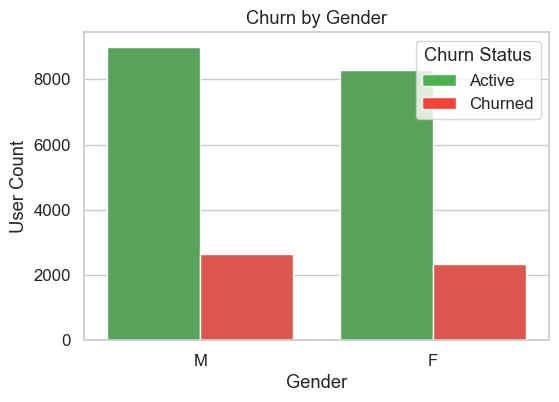

In [31]:
gender_churn = (
    data.select("userId", "gender", "churn_flag").distinct()
        .groupBy("gender", "churn_flag").count()
        .toPandas()
)

plt.figure(figsize=(6,4))
bar = sns.barplot(
    data=gender_churn, 
    x="gender", 
    y="count", 
    hue="churn_flag", 
    palette={0: "#4CAF50", 1: "#F44336"}
)
plt.title("Churn by Gender")
plt.xlabel("Gender")
plt.ylabel("User Count")
# Make custom legend matching color to 'Active' and 'Churned'
from matplotlib.patches import Patch
legend_colors = ["#4CAF50", "#F44336"]
legend_labels = ["Active", "Churned"]
handles = [Patch(facecolor=c, label=l) for c, l in zip(legend_colors, legend_labels)]
plt.legend(handles=handles, title="Churn Status")
plt.show()

### V. User activity intensity

In [16]:
activity = (
    data.groupBy("userId", "churn_flag")
        .agg(
            F.countDistinct("sessionId").alias("num_sessions"),
            F.count(F.when(F.col("page") == "NextSong", True)).alias("songs_played")
        )
)
activity.groupBy("churn_flag").agg(
    F.avg("num_sessions").alias("avg_sessions"),
    F.avg("songs_played").alias("avg_songs")
).show()

+----------+------------------+-----------------+
|churn_flag|      avg_sessions|        avg_songs|
+----------+------------------+-----------------+
|         1|12.300219868079152|876.7291625024985|
|         0|22.786685962373372|953.0533140376266|
+----------+------------------+-----------------+



### VI. Feature correlations (behavior vs churn)

In [17]:
from pyspark.sql.functions import avg

# Thumbs Up / Thumbs Down / Add to Playlist patterns
interactions = (
    data.groupBy("userId", "churn_flag")
        .agg(
            F.count(F.when(F.col("page") == "Thumbs Up", True)).alias("thumbs_up"),
            F.count(F.when(F.col("page") == "Thumbs Down", True)).alias("thumbs_down"),
            F.count(F.when(F.col("page") == "Add to Playlist", True)).alias("add_playlist")
        )
)
interactions.groupBy("churn_flag").agg(
    avg("thumbs_up").alias("avg_thumbs_up"),
    avg("thumbs_down").alias("avg_thumbs_down"),
    avg("add_playlist").alias("avg_add_playlist")
).show()

+----------+------------------+------------------+------------------+
|churn_flag|     avg_thumbs_up|   avg_thumbs_down|  avg_add_playlist|
+----------+------------------+------------------+------------------+
|         1|44.867479512292626|11.124525284829103| 24.91625024985009|
|         0| 53.66095513748191|10.625528219971056|27.395947901591896|
+----------+------------------+------------------+------------------+



### VII. Engagement duration

In [18]:
span = (
    data.groupBy("userId", "churn_flag")
        .agg((F.max("ts") - F.min("ts")).alias("active_span"))
)
span.groupBy("churn_flag").agg(F.avg("active_span").alias("avg_active_span")).show()

+----------+--------------------+
|churn_flag|     avg_active_span|
+----------+--------------------+
|         1|2.1038014655206876E9|
|         0|3.9549876430680175E9|
+----------+--------------------+



/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_73969/3285936059.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=activity_summary, x=["Active", "Churned"], y="avg_sessions", ax=ax[0], palette=["#4CAF50", "#F44336"])
/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_73969/3285936059.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=activity_summary, x=["Active", "Churned"], y="avg_songs", ax=ax[1], palette=["#4CAF50", "#F44336"])


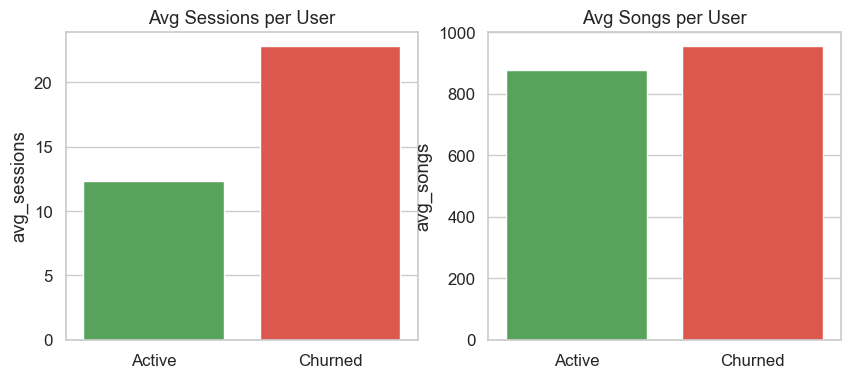

In [37]:
activity_summary = (
    data.groupBy("userId", "churn_flag")
        .agg(
            F.countDistinct("sessionId").alias("num_sessions"),
            F.count(F.when(F.col("page") == "NextSong", True)).alias("num_songs")
        )
        .groupBy("churn_flag")
        .agg(
            F.avg("num_sessions").alias("avg_sessions"),
            F.avg("num_songs").alias("avg_songs")
        )
        .toPandas()
)

fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(data=activity_summary, x=["Active", "Churned"], y="avg_sessions", ax=ax[0], palette=["#4CAF50", "#F44336"])
sns.barplot(data=activity_summary, x=["Active", "Churned"], y="avg_songs", ax=ax[1], palette=["#4CAF50", "#F44336"])
ax[0].set_title("Avg Sessions per User")
ax[1].set_title("Avg Songs per User")
plt.show()